In [9]:
import numpy as np

import itertools
import os
import shutil
import random
import glob
import cv2

%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from keras.layers import InputLayer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy


from sklearn.model_selection import train_test_split


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Extracting Dataset using Kaggle API


In [10]:
# installing the Kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Importing the Dog vs Cat Dataset from Kaggle**

In [8]:
# Kaggle api 
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:36<00:00, 25.0MB/s]
100% 812M/812M [00:36<00:00, 23.3MB/s]


In [12]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [13]:
# extracting the compressed dataset
from zipfile import ZipFile

dataset = '/content/dogs-vs-cats.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [14]:
# extracting the compressed train dataset
from zipfile import ZipFile

dataset = '/content/train.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The train is extracted')

The train is extracted


In [15]:
# counting the number of files in train folder
path, dirs, files = next(os.walk('/content/train'))
file_count = len(files)
print('Number of images: ', file_count)
# printing the name of images
file_names = os.listdir('/content/train/')
print(file_names[0:5])


Number of images:  25000
['cat.7824.jpg', 'cat.9435.jpg', 'cat.12125.jpg', 'cat.12170.jpg', 'cat.6704.jpg']


In [16]:
dog_count = 0
cat_count = 0

for img_file in file_names:
  name = img_file[0:3]
  if name == "dog":
    dog_count += 1
  else:
    cat_count += 1

print(f'Number of dog images: {dog_count}\nNumber of cat images: {cat_count}')


Number of dog images: 12500
Number of cat images: 12500


**Displaying the images of dogs and cats**

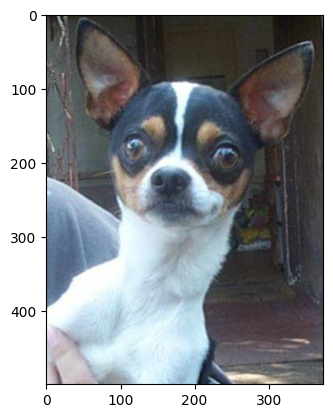

In [17]:
img_dog = mpimg.imread("/content/train/dog.12253.jpg")
imgplt = plt.imshow(img_dog)
plt.show()

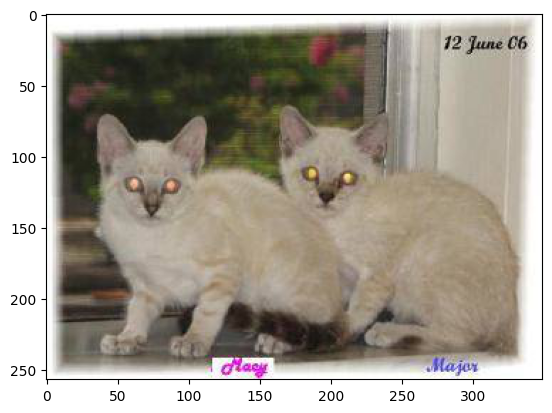

In [18]:
img_dog = mpimg.imread("/content/train/cat.12125.jpg")
imgplt = plt.imshow(img_dog)
plt.show()

As can be seen, the images are in different sizes we must make them the same size.

**Resizing all the images**

In [19]:
# creating a directory for resized images
os.mkdir("/content/image_resized")

In [20]:
origin_folder = '/content/train/'
resized_folder = '/content/image_resized/'

for i in range(2000):
  filename = os.listdir(origin_folder)[i]
  img_path = origin_folder+filename

  img = Image.open(img_path)
  img = img.resize((224, 224))
  img = img.convert('RGB')

  newImg_path = resized_folder+filename
  img.save(newImg_path)


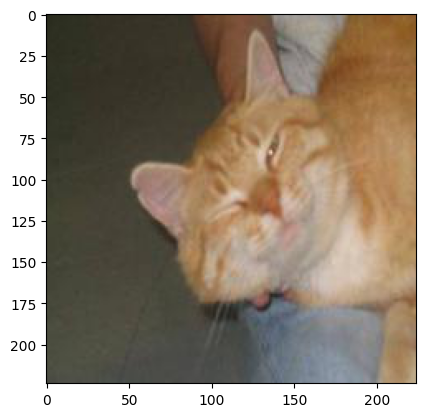

In [21]:
# display resized cat image
img = mpimg.imread('/content/image_resized/cat.250.jpg')
imgplt = plt.imshow(img)
plt.show()

**Creating labels for resized images of dogs and cats**

cat : 0

dog : 1


In [22]:
# creating a for loop to assign labels
filenames = os.listdir('/content/image_resized/')

labels = []

for i in range(2000):
  file_name = filenames[i]
  label = file_name[0:3]
  labels.append(1) if label == 'dog' else labels.append(0)
  
print(f'{filenames[0:5]}\n {len(filenames)}\n {labels[0:5]}')

['cat.7824.jpg', 'cat.9435.jpg', 'cat.12125.jpg', 'cat.12170.jpg', 'cat.6704.jpg']
 2000
 [0, 0, 0, 0, 0]


In [23]:
# counting the images of dogs and cats out of 2000 images
values, counts = np.unique(labels, return_counts=True)
print(f'{values}\n{counts}')

[0 1]
[ 964 1036]


**Converting all the resized images to numpy array**

In [24]:
image_directory = '/content/image_resized/'
image_extension = ['png', 'jpg']

files = []
[files.extend(glob.glob(image_directory + '*.' + i)) for i in image_extension]

dogcatImg_arr = np.asarray([cv2.imread(file) for file in files])
print(f'{dogcatImg_arr[0:5]}\n {type(dogcatImg_arr)}\n {dogcatImg_arr.shape}')

[[[[194 185 182]
   [189 180 177]
   [197 188 185]
   ...
   [154 148 135]
   [150 144 131]
   [146 140 127]]

  [[194 185 182]
   [191 182 179]
   [201 192 189]
   ...
   [151 145 132]
   [148 142 129]
   [145 139 126]]

  [[199 190 187]
   [195 186 183]
   [206 197 194]
   ...
   [151 145 132]
   [150 144 131]
   [147 141 128]]

  ...

  [[104 107  98]
   [105 108  99]
   [115 118 109]
   ...
   [194 183 186]
   [186 174 180]
   [183 171 177]]

  [[107 108  99]
   [112 113 104]
   [123 124 115]
   ...
   [185 174 177]
   [184 172 178]
   [192 180 186]]

  [[109 110 101]
   [116 117 108]
   [128 129 120]
   ...
   [195 184 187]
   [192 180 186]
   [193 181 187]]]


 [[[115 137 149]
   [115 137 149]
   [116 138 150]
   ...
   [104 114 108]
   [101 111 105]
   [ 99 109 103]]

  [[119 141 153]
   [119 141 153]
   [119 141 153]
   ...
   [106 116 110]
   [106 116 110]
   [105 115 109]]

  [[119 140 155]
   [119 140 155]
   [119 140 155]
   ...
   [109 119 113]
   [110 120 114]
   [111 121

In [25]:
X = dogcatImg_arr
y = np.asarray(labels)

**Train Test Split**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(f'Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}')

Shape of X Train: (1600, 224, 224, 3)
Shape of y Train: (1600,)
Shape of X Test: (400, 224, 224, 3)
Shape of y Test: (400,)


**Scaling Data**

In [27]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
print(X_train_scaled)

[[[[0.01568627 0.01960784 0.01176471]
   [0.01176471 0.01568627 0.00784314]
   [0.01176471 0.01568627 0.00784314]
   ...
   [0.15294118 0.19607843 0.2745098 ]
   [0.18431373 0.22745098 0.30588235]
   [0.14509804 0.18823529 0.26666667]]

  [[0.01176471 0.01568627 0.00784314]
   [0.01176471 0.01568627 0.00784314]
   [0.01176471 0.01568627 0.00784314]
   ...
   [0.14901961 0.19215686 0.27058824]
   [0.18431373 0.22745098 0.30588235]
   [0.14509804 0.18823529 0.26666667]]

  [[0.00392157 0.00784314 0.        ]
   [0.00784314 0.01176471 0.00392157]
   [0.00784314 0.00784314 0.00784314]
   ...
   [0.14901961 0.19215686 0.27058824]
   [0.18431373 0.22745098 0.30588235]
   [0.14901961 0.19215686 0.27058824]]

  ...

  [[0.02745098 0.0745098  0.08235294]
   [0.04313725 0.08235294 0.10980392]
   [0.04313725 0.07843137 0.12941176]
   ...
   [0.15686275 0.18431373 0.25882353]
   [0.12941176 0.15686275 0.23137255]
   [0.09411765 0.12156863 0.19607843]]

  [[0.03137255 0.05098039 0.13333333]
   [0.0

**Bulding the Neural Network with MobileNet v2**

In [28]:
def load_model(model_path):
    with keras.utils.custom_object_scope({'KerasLayer': hub.KerasLayer, 'InputLayer': InputLayer}):
        model = load_model(model_path)
    return model

In [29]:
mobilenet_model_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [30]:
model_mobileNet = tf.keras.Sequential([
    hub.KerasLayer(mobilenet_model_url, input_shape=(224,224,3), trainable=False),
    tf.keras.layers.Dense(2, activation='softmax')
    
])
model_mobileNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
model_mobileNet.compile(
  optimizer='Adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model_mobileNet.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
50/50 [==============================] - 14s 39ms/step - loss: 0.2058 - accuracy: 0.9244
Epoch 2/2
50/50 [==============================] - 2s 42ms/step - loss: 0.0683 - accuracy: 0.9806


In [32]:
score, acc = model_mobileNet.evaluate(X_test_scaled, y_test)
print(f'Test Loss = {score}\nTest Accuracy = {acc}')

13/13 [==============================] - 2s 78ms/step - loss: 0.0570 - accuracy: 0.9850
Test Loss = 0.05698554962873459
Test Accuracy = 0.9850000143051147


In [36]:
model_mobileNet.save("/content/Models/cats_dogs_classifierv2.h5")